# Train a GAN to generate and recognize sine curves

In [31]:
%matplotlib inline
import torch
import numpy as np
import pylab as pl
from torch import nn
torch.set_default_tensor_type(torch.FloatTensor)

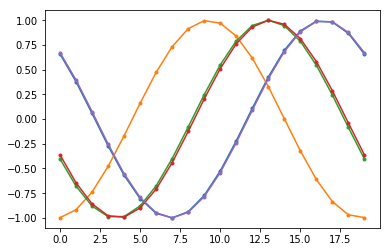

In [32]:
def true_data_gen(size=20, batch_size=5):
    return torch.from_numpy(np.sin(2*np.pi*np.linspace(0,1,size).reshape(1,-1).repeat(batch_size,0)+2*np.pi*np.random.random(batch_size).reshape(batch_size,-1))).float()
pl.plot(true_data_gen().numpy().T,'.-')

In [33]:
class Generator(nn.Module):
    def __init__(self, in_size=5, out_size=20, n_hidden=3, hidden_size=20):
        super(Generator, self).__init__()
        self.input = nn.Linear(in_size,hidden_size)
        self.hidden = nn.Linear(hidden_size,hidden_size)
        self.output = nn.Linear(hidden_size,out_size)
        self.n_hidden = n_hidden
        self.in_size = in_size
    def forward(self, x):
        x = torch.tanh(self.input(x))
        for n in range(self.n_hidden):
            x = torch.tanh(self.hidden(x))
        x = torch.tanh(self.output(x))
        return x

class  Discriminator(nn.Module):
    def __init__(self, in_size=20, out_size=1, n_hidden=3, hidden_size=20):
        super(Discriminator, self).__init__()
        self.input = nn.Linear(in_size,hidden_size)
        self.hidden = nn.Linear(hidden_size,hidden_size)
        self.output = nn.Linear(hidden_size,out_size)
        self.n_hidden = n_hidden
    def forward(self, x):
        x = torch.tanh(self.input(x))
        for n in range(self.n_hidden):
            x = torch.tanh(self.hidden(x))
        x = torch.sigmoid(self.output(x))
        return x

epoch 0
epoch 400
epoch 800
epoch 1200
epoch 1600
epoch 2000


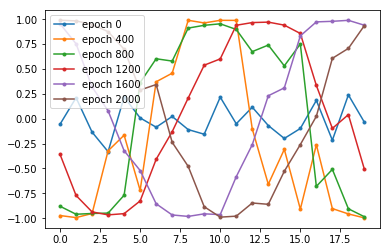

In [36]:
G = Generator(in_size=5, out_size=20, n_hidden=3, hidden_size=20)
D = Discriminator(in_size=20, out_size=1, n_hidden=3, hidden_size=20)

def fake_data_gen(size=20, batch_size=5, in_size=5, detach=True):
    if detach:
        return G(torch.randn(batch_size, in_size)).detach()
    else:
        return G(torch.randn(batch_size, in_size))

d_learning_rate = 1e-3
g_learning_rate = 1e-3
optim_betas = (0.9, 0.999)
batch_size = 10
num_epochs = 2001
disp_interval = 400
d_steps = 10
g_steps = 5
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
d_optimizer = torch.optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = torch.optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)


fig = pl.figure(1,figsize=(6,4))
for epoch in range(num_epochs):
    for d in range(d_steps):
        D.zero_grad()
        real_sample = true_data_gen(batch_size=batch_size, size=20)
        d_real_err = criterion(D(real_sample),torch.ones(batch_size, 1))
        d_real_err.backward()
#        d_optimizer.step()
#        D.zero_grad()
        if np.random.random()<0.95:
            fake_sample = fake_data_gen(batch_size=batch_size, size=20)
        else:
            fake_sample = torch.randn(batch_size,20)
        d_fake_err = criterion(D(fake_sample),torch.zeros(batch_size, 1))
        d_fake_err.backward()
        d_optimizer.step()
    for g in range(g_steps):
        G.zero_grad()
        fake_sample = fake_data_gen(batch_size=batch_size, size=20,detach=False)
        g_err = criterion(D(fake_sample),torch.ones(batch_size, 1))
        g_err.backward()
        g_optimizer.step()
    if epoch % disp_interval == 0:
        print(r'epoch %d' % epoch)
        pl.plot(G(torch.randn(G.in_size)).detach().numpy(),'.-',label=('epoch %d' % epoch))
        pl.legend(loc='best', prop={'size':10})

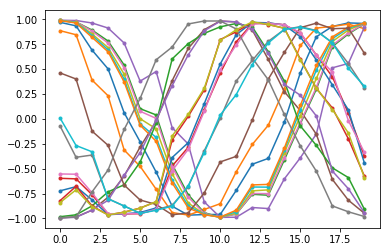

In [38]:
pl.plot(G(torch.randn(20, G.in_size)).detach().numpy().T,'.-')